# Grupo 6
## Integrantes 
- Pablo Sarzosa
- Elisa Herrera
- Doménica Rodríguez 
- Andrés Albarracín

# 7.7. Redes densamente conectadas (DenseNet)

ResNet cambió significativamente la visión de cómo parametrizar las funciones en redes profundas. DenseNet (red convolucional densa) es, hasta cierto punto, la extensión lógica de esto [Huang et al., 2017]. Para entender cómo llegar a él, tomemos un pequeño desvío hacia las matemáticas.
## 7.7.1. De ResNet a DenseNet
Recuerde la expansión de Taylor para funciones. Para el punto x=0 se puede escribir como

   f(x)=f(0)+f′(0)x+f′′(0)2!x2+f′′′(0)3!x3+….
   
El punto clave es que descompone una función en términos de orden cada vez mayor. De manera similar, ResNet descompone funciones en

f(x)=x+g(x).

Es decir, ResNet descompone f en un término lineal simple y uno no lineal más complejo. ¿Qué pasa si queremos capturar (no necesariamente agregar) información más allá de dos términos? Una solución fue DenseNet [Huang et al., 2017].

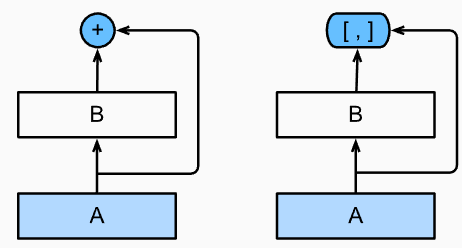

Fig. 7.7.1 La principal diferencia entre ResNet (izquierda) y DenseNet (derecha) en conexiones entre capas: uso de suma y uso de concatenación.

Como se muestra en la Fig. 7.7.1, la diferencia clave entre ResNet y DenseNet es que, en el último caso, las salidas se concatenan (indicadas por [,] ) en lugar de sumarse. Como resultado, realizamos un mapeo de x a sus valores después de aplicar una secuencia de funciones cada vez más compleja:

x→[x,f1(x),f2([x,f1(x)]),f3([x,f1(x),f2([x,f1(x)])]),…].

Al final, todas estas funciones se combinan en MLP para reducir nuevamente la cantidad de características. En términos de implementación, esto es bastante simple: en lugar de agregar términos, los concatenamos. El nombre DenseNet surge del hecho de que el gráfico de dependencia entre variables se vuelve bastante denso. La última capa de tal cadena está densamente conectada a todas las capas anteriores. Las conexiones densas se muestran en la Fig. 7.7.2.

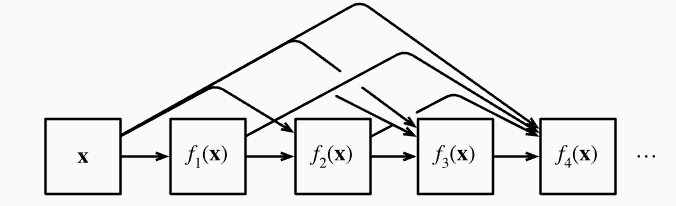

Fig. 7.7.2 Conexiones densas en DenseNet.

## 7.7.2. Bloques densos
DenseNet utiliza la estructura modificada de "normalización, activación y convolución por lotes" de ResNet (consulte el ejercicio en la Sección 7.6). Primero, implementamos esta estructura de bloque de convolución.

In [1]:
use strict;
use warnings;
use Data::Dump qw(dump);
use Data::Dumper qw(Dumper);
use AI::MXNet qw(mx);
use d2l;
use d2l::Animator;
use d2l::Accumulator;
use d2l::Timer;
IPerl->load_plugin('Chart::Plotly');

In [2]:
sub conv_block {
    my ($num_channels) = @_;
    my $blk = mx->gluon->nn->Sequential();
    $blk->add(mx->gluon->nn->BatchNorm(),
              mx->gluon->nn->Activation('relu'),
              mx->gluon->nn->Conv2D($num_channels, kernel_size=>3, padding=>1));
              return $blk;
              }

Un bloque denso consta de varios bloques de convolución, cada uno de los cuales utiliza el mismo número de canales de salida. En la propagación directa, sin embargo, concatenamos la entrada y la salida de cada bloque de convolución en la dimensión del canal.

In [3]:
package DenseBlock{
use strict;
use warnings;
use Data::Dump qw(dump);
use AI::MXNet qw(mx);
use base qw(AI::MXNet::Gluon::Block);
}

sub new {
    my ($class, $num_convs, $num_channels, %args) = (shift,@_);
    my $self = $class->SUPER::new(%args);
    $self->net(mx->gluon->nn->Sequential());
    for (my $i = 0; $i < $num_convs; $i++) {
        $self->net->add(conv_block($num_channels)); # agrega el bloque de convolución al modelo
    }
    return $self;
}

sub forward{
    my ($self, $X) = @_;
    for my $blk (@{$self->net}) {
        my $Y = $blk->($X); # aplica el bloque al tensor de entrada
        $X = mx->nd->concat(($X, $Y), axis=>1); # concatena la entrada y la salida del bloque en la dimensión del canal
    }
    return $X;
}

En el siguiente ejemplo, definimos una instancia de DenseBlock con 2 bloques de convolución de 10 canales de salida. Al usar una entrada con 3 canales, obtendremos una salida con 3+2×10=23 canales El número de canales de bloque de convolución controla el crecimiento del número de canales de salida en relación con el número de canales de entrada. Esto también se conoce como la tasa de crecimiento.

In [4]:
my $blk = DenseBlock->new(2, 10);
$blk->initialize(mx->init->Xavier(), force_reinit => 1);
my $X = mx->nd->random->uniform(shape=>[4, 3, 8, 8]);


<AI::MXNet::NDArray 4x3x8x8 @cpu(0)>

In [5]:
sub transition_block {
    my ($num_channels) = @_;
    my $blk = mx->gluon->nn->Sequential();
    $blk->add(mx->gluon->nn->BatchNorm(),
              mx->gluon->nn->Activation('relu'),
              mx->gluon->nn->Conv2D($num_channels, kernel_size => 1),
              mx->gluon->nn->AvgPool2D(pool_size => 2, strides => 2));
    return $blk;
}

Aplique una capa de transición con 10 canales a la salida del bloque denso en el ejemplo anterior. Esto reduce el número de canales de salida a 10 y reduce a la mitad el alto y el ancho.

In [11]:
my $blk = transition_block(10);
$blk->initialize(mx->init->Xavier(), force_reinit => 1);
my $out = $blk->($Y);
print $out->shape();

## 7.7.4. Modelo DenseNet
A continuación, construiremos un modelo DenseNet. DenseNet primero usa la misma capa convolucional única y la capa de agrupación máxima que en ResNet.

In [12]:
my $net = mx->gluon->nn->Sequential();
$net->add(mx->gluon->nn->Conv2D(64, kernel_size=>7, strides=>2, padding=>3),
          mx->gluon->nn->BatchNorm(),
          mx->gluon->nn->Activation('relu'),
          mx->gluon->nn->MaxPool2D(pool_size=>3, strides=>2, padding=>1));

Luego, similar a los cuatro módulos compuestos por bloques residuales que usa ResNet, DenseNet usa cuatro bloques densos. Similar a ResNet, podemos establecer la cantidad de capas convolucionales utilizadas en cada bloque denso. Aquí, lo configuramos en 4, de acuerdo con el modelo ResNet-18 en la Sección 7.6. Además, establecemos el número de canales (es decir, la tasa de crecimiento) para las capas convolucionales en el bloque denso en 32, por lo que se agregarán 128 canales a cada bloque denso.

En ResNet, la altura y el ancho se reducen entre cada módulo por un bloque residual con un paso de 2. Aquí, usamos la capa de transición para reducir a la mitad la altura y el ancho y reducir a la mitad el número de canales.

In [13]:
my $num_channels = 64;
my $growth_rate = 32;
my @num_convs_in_dense_blocks = (4, 4, 4, 4);

foreach my $i (0..$#num_convs_in_dense_blocks) {
$net->add(DenseBlock($num_convs_in_dense_blocks[$i], $growth_rate));
$num_channels += $num_convs_in_dense_blocks[$i] * $growth_rate;
if ($i != $#num_convs_in_dense_blocks) {
$num_channels = int($num_channels / 2);
$net->add(transition_block($num_channels));
    }
}

Error: Undefined subroutine &main::DenseBlock called at reply input line 6.


De manera similar a ResNet, una capa de agrupación global y una capa totalmente conectada se conectan al final para producir la salida.

In [14]:
$net->add(mx->gluon->nn->nn->BatchNorm(), 
          mx->gluon->nn->nn->Activation('relu'), 
          mx->gluon->nn->nn->GlobalAvgPool2D(),
          mx->gluon->nn->nn->Dense(10));

Error: Can't locate object method "nn" via package "AI::MXNet::Gluon::NN" at reply input line 1.


## 7.7.5. Entrenamiento 
Dado que aquí estamos usando una red más profunda, en esta sección reduciremos la altura y el ancho de entrada de 224 a 96 para simplificar el cálculo.

In [ ]:
my ($lr, $num_epochs, $batch_size) = (0.1, 10, 256);
my ($train_iter, $test_iter) = d2l->load_data_fashion_mnist(batch_size => $batch_size, resize => 96);
d2l->train_ch6($net, $train_iter, $test_iter, $num_epochs, $lr, d2l->try_gpu());

In [ ]:
my ($model_file_name, $is_train, $animator) = ('DenseNet.mdl', 1);

if ($is_train){
  $animator = d2l->train_ch6($net, $train_iter, $test_iter, $num_epochs, $lr, d2l->try_gpu());
  $net->save_parameters($model_file_name);
  $animator->plot;

}else{
  $net->load_parameters($model_file_name);
}

## 7.7.6. Resumen
En términos de conexiones entre capas, a diferencia de ResNet, donde las entradas y salidas se suman, DenseNet concatena entradas y salidas en la dimensión del canal.

Los componentes principales que componen DenseNet son bloques densos y capas de transición.

Necesitamos mantener la dimensionalidad bajo control al componer la red agregando capas de transición que reducen nuevamente la cantidad de canales.
## 7.7.7. Ejercicios
¿Por qué usamos la agrupación promedio en lugar de la agrupación máxima en la capa de transición?

Una de las ventajas mencionadas en el documento de DenseNet es que los parámetros de su modelo son más pequeños que los de ResNet. ¿Por qué es este el caso?

Un problema por el que se ha criticado a DenseNet es su alto consumo de memoria.

¿Es este realmente el caso? Intenta cambiar la forma de entrada a 224 × 224
   para ver el consumo real de memoria de la GPU.

¿Puede pensar en un medio alternativo para reducir el consumo de memoria? ¿Cómo necesitarías cambiar el marco?

Implemente las diversas versiones de DenseNet presentadas en la Tabla 1 del documento de DenseNet [Huang et al., 2017].

Diseñe un modelo basado en MLP aplicando la idea de DenseNet. Aplíquelo a la tarea de predicción del precio de la vivienda en la Sección 4.10.